In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from seminartools.data import read_inflation
from seminartools.models.pca_var_model import PCAVARModel

# 1. Read data

In [7]:
df_inflation = read_inflation(mergeable_format=True).reset_index()
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


# 2. AR model per country

In [8]:
model = PCAVARModel(num_pcs=3, lags = [1, 2, 3, 4], standardize_pre_post = True)
model

In [9]:
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


In [10]:
#model.fit(df_inflation.query("yearmonth <= '2010-01-01'"))
model.fit(df_inflation)

Text(0.5, 1.0, 'Fraction of variance explained by each principal component')

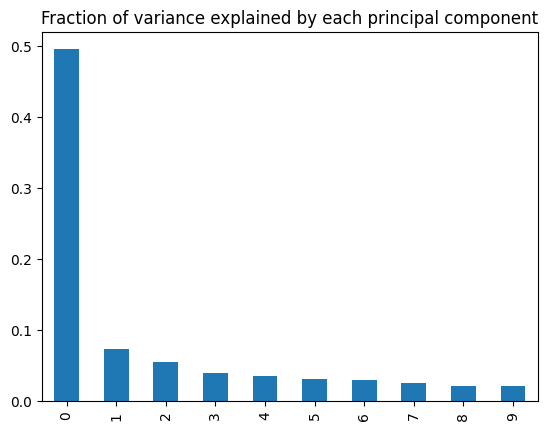

In [11]:
import matplotlib.pyplot as plt

pd.Series(model.all_eigenvalues).pipe(lambda x: x / x.sum()).head(10).plot.bar()
plt.title("Fraction of variance explained by each principal component")

In [12]:
(model.all_eigenvalues[0] + model.all_eigenvalues[1]) / sum(model.all_eigenvalues)

0.5687738462307839

PC1 and PC2 seem to combine 95% of the variance in inflation together.

<Axes: xlabel='country'>

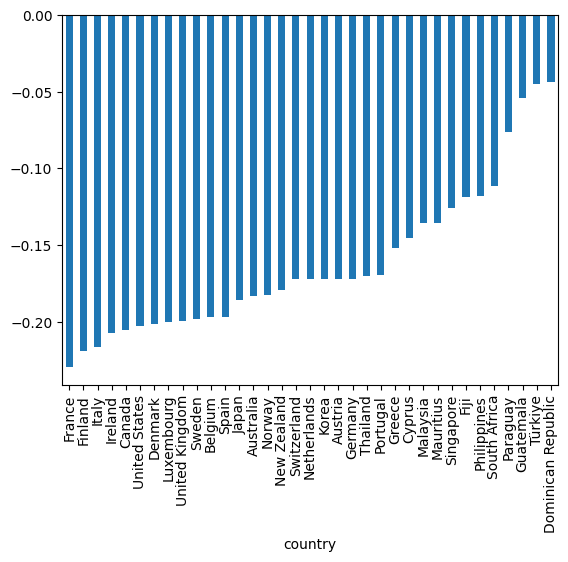

In [13]:
pd.Series(model.all_eigenvectors[:, 0], index = model.data_wide_columns).sort_values().plot.bar()

PC1 dominated by Peru and Argentina

# 3. Evaluation

In [14]:
df_inflation["Country"].unique()

KeyError: 'Country'

In [15]:
preds = model.predict(df_inflation)
preds

,date,country,inflation
7105,2023-04-01,Australia,0.017092
7106,2023-04-01,Austria,0.012846
7107,2023-04-01,Belgium,0.014540
7108,2023-04-01,Canada,0.014357
7109,2023-04-01,Cyprus,0.012994
7110,2023-04-01,Denmark,0.016212
7111,2023-04-01,Dominican Republic,0.015865
7112,2023-04-01,Fiji,0.017616
7113,2023-04-01,Finland,0.017930
7114,2023-04-01,France,0.016052


# 4. H-period ahead forecasting

In [16]:
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


In [17]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(model, df_inflation, "2010-01-01", h=1)
forecast

,date,country,inflation
0,2010-01-01,Australia,0.002320
1,2010-01-01,Austria,0.004068
2,2010-01-01,Belgium,0.002383
3,2010-01-01,Canada,0.001628
4,2010-01-01,Cyprus,0.002048
...,...,...,...
1850,2023-01-01,Switzerland,0.007417
1851,2023-01-01,Thailand,0.013729
1852,2023-01-01,Türkiye,0.030701
1853,2023-01-01,United Kingdom,0.020489


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data = forecast,
    x = "yearmonth",
    y = "inflation",
    hue = "Country"
)
# turn off legend
plt.legend().remove()

ValueError: Could not interpret value `yearmonth` for `x`. An entry with this name does not appear in `data`.

# 5. Compare the forecast with the actual data

In [22]:
forecast_merged = forecast.copy().rename(columns={"inflation": "pred"})
forecast_merged = forecast_merged.merge(
    df_inflation[["country", "date", "inflation"]],
    on=["country", "date"],
    how="left",
).rename(columns={"inflation": "actual"})
forecast_merged.tail(100)

,date,country,pred,actual
1755,2022-07-01,Denmark,0.018579,0.023957
1756,2022-07-01,Dominican Republic,0.022500,0.013293
1757,2022-07-01,Fiji,0.022470,0.007368
1758,2022-07-01,Finland,0.020946,0.016000
1759,2022-07-01,France,0.018620,0.011638
...,...,...,...,...
1850,2023-01-01,Switzerland,0.007417,0.010084
1851,2023-01-01,Thailand,0.013729,0.000463
1852,2023-01-01,Türkiye,0.030701,0.116249
1853,2023-01-01,United Kingdom,0.020489,0.008814


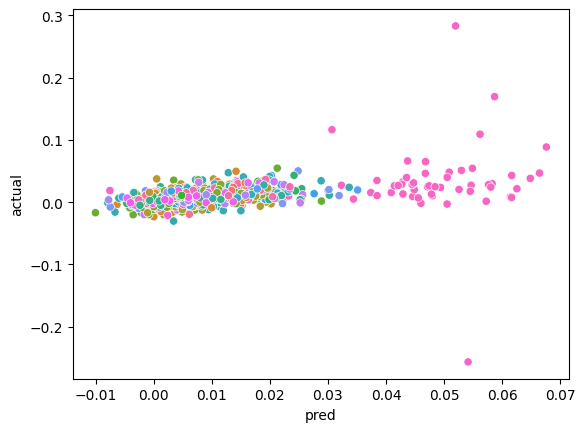

In [25]:
sns.scatterplot(
    data = forecast_merged,
    x = "pred",
    y = "actual",
    hue = "country"
)
plt.legend().remove()

In [26]:
import statsmodels.api as sm

sm.OLS(
    forecast_merged["actual"], sm.add_constant(forecast_merged["pred"])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     449.4
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           1.74e-89
Time:                        08:23:54   Log-Likelihood:                 5456.6
No. Observations:                1855   AIC:                        -1.091e+04
Df Residuals:                    1853   BIC:                        -1.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.499      0.000       0.001       0.002
pred           0.6832      0.032     21.200      0.000       0.620       0.746
==============================================================================
Omnibus:                     1398.235   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4188171.936
Skew:                          -1.921   Prob(JB):                         0.00
Kurtosis:                     235.748   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
model.var.models["PC1"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PC1   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     77.80
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           9.02e-67
Time:                        08:23:55   Log-Likelihood:                -395.08
No. Observations:                 204   AIC:                             816.2
Df Residuals:                     191   BIC:                             859.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.122      0.072      0.943      -0.231       0.249
PC1_lag_1      0.4858      0.072      6.715      0.000       0.343       0.628
PC2_lag_1     -0.4009      0.118     -3.386      0.001      -0.634      -0.167
PC3_lag_1      0.3498      0.156      2.243      0.026       0.042       0.657
PC1_lag_2      0.1089      0.080      1.369      0.173      -0.048       0.266
PC2_lag_2     -0.0804      0.134     -0.599      0.550      -0.345       0.184
PC3_lag_2     -0.0635      0.166     -0.383      0.702      -0.390       0.263
PC1_lag_3      0.0745      0.081      0.925      0.356      -0.084       0.233
PC2_lag_3      0.3066      0.134      2.287      0.023       0.042       0.571
PC3_lag_3     -0.0613      0.162     -0.379      0.705      -0.380       0.258
PC1_lag_4      0.2929      0.074      3.940      0.000       0.146       0.439
PC2_lag_4      0.1360      0.121      1.120      0.264      -0.103       0.376
PC3_lag_4     -0.0123      0.153     -0.080      0.936      -0.313       0.289
==============================================================================
Omnibus:                       15.537   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.280
Skew:                          -0.007   Prob(JB):                     3.28e-11
Kurtosis:                       5.383   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Eval standardisation

In [29]:
from seminartools.models.utils import get_stats
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.time_series_split import ExpandingWindowSplit
from seminartools.models.uc_sv_ss_model import UCSVSSModel

tss = ExpandingWindowSplit(start_date = "2000-01-01")
tss

stats = get_stats(
    [
        ("pca_var_no_standardisation", lambda: PCAVARModel(standardize_pre_post=False)),
        ("pca_var_standardisation", lambda: PCAVARModel(standardize_pre_post=True)),
        (
            "uc_sv",
            lambda: UCSVSSModel(num_particles=10000, stochastic_seasonality=False),
        ),
    ],
    df_inflation,
    tss,
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/statsmodels/base/model.py:1906: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


,mse,mae,r2,mz_intercept,mz_slope,mz_r2,mz_wald_test_statistic,p-value
pca_var_no_standardisation,0.000196,0.007812,0.129361,0.002956,0.592753,0.245376,250.057582,9.585578123350095e-102
pca_var_standardisation,0.000272,0.008487,-0.207035,0.003563,0.417599,0.200074,827.779696,2.4732401446159103e-291
